In [2]:
# Upload Raw Images to S3
import boto3
import dotenv
import os

dotenv.load_dotenv()
rc = boto3.client('rekognition')
s3 = boto3.client('s3')


In [3]:
local_image_path = "./Images"
jpg_path_list = []
for file_name in os.listdir(local_image_path):
    extension = file_name.split(".")[-1]
    if extension == "jpg":
        jpg_path_list.append((os.path.join(local_image_path, file_name), file_name))

In [4]:
# Upload files
bucket_name = "techcatalyst-raw"
key_name = "Ben/AI/IMAGES_RAW/"
# for jpg_path in jpg_path_list:
#     print(jpg_path[0])
#     s3.upload_file(jpg_path[0], bucket_name, (key_name + jpg_path[1]))


In [5]:
# List of car makes to search for (already uppercase)
car_makes = [
    'TOYOTA', 'HONDA', 'FORD', 'CHEVROLET', 'NISSAN', 'JEEP', 'HYUNDAI', 'KIA',
    'SUBARU', 'RAM', 'GMC', 'BMW', 'MERCEDES-BENZ', 'LEXUS', 'AUDI', 'VOLKSWAGEN',
    'TESLA', 'ACURA', 'CADILLAC', 'CHRYSLER', 'DODGE', 'INFINITI', 'LINCOLN', 'MAZDA'
]

# List of full US state names for searching
us_state_names = [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut',
    'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa',
    'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
    'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
    'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina',
    'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island',
    'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
    'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming', 'District of Columbia'
]

In [6]:
raw_images_objects = s3.list_objects_v2(Bucket=bucket_name, Prefix=key_name)['Contents']
response_list = []

for image_contents in raw_images_objects:
    image_key = image_contents['Key']
    response_list.append(rc.detect_text(
        Image={'S3Object' : {'Bucket' : bucket_name, 'Name' : image_key}}
    ))
print(response_list)


[{'TextDetections': [{'DetectedText': 'VA 4164979', 'Type': 'LINE', 'Id': 0, 'Confidence': 99.38411712646484, 'Geometry': {'BoundingBox': {'Width': 0.10272216796875, 'Height': 0.0400390625, 'Left': 0.0999755859375, 'Top': 0.1748046875}, 'Polygon': [{'X': 0.0999755859375, 'Y': 0.1748046875}, {'X': 0.20269775390625, 'Y': 0.1748046875}, {'X': 0.20269775390625, 'Y': 0.21484375}, {'X': 0.0999755859375, 'Y': 0.21484375}]}}, {'DetectedText': 'NOV', 'Type': 'LINE', 'Id': 1, 'Confidence': 100.0, 'Geometry': {'BoundingBox': {'Width': 0.10009339451789856, 'Height': 0.0958026796579361, 'Left': 0.10553361475467682, 'Top': 0.22323094308376312}, 'Polygon': [{'X': 0.10553361475467682, 'Y': 0.22713987529277802}, {'X': 0.20447833836078644, 'Y': 0.22323094308376312}, {'X': 0.20562700927257538, 'Y': 0.3151246905326843}, {'X': 0.10668228566646576, 'Y': 0.3190336227416992}]}}, {'DetectedText': 'VIRGINIA', 'Type': 'LINE', 'Id': 2, 'Confidence': 98.82801055908203, 'Geometry': {'BoundingBox': {'Width': 0.43938

In [7]:
state_detected_license_plates = {}
make_detected_license_plates = {}
for response in response_list:
    for text in response["TextDetections"]:
        capitalized_text = text['DetectedText'].lower().capitalize() 
        upper_text = text['DetectedText'].upper()
        if capitalized_text in us_state_names:
            if capitalized_text in state_detected_license_plates:
                state_detected_license_plates[capitalized_text] += 1
            else:
                state_detected_license_plates[capitalized_text] = 1
        elif upper_text in car_makes:
            if upper_text in make_detected_license_plates:
                make_detected_license_plates[upper_text] += 1
            else:
                make_detected_license_plates[upper_text] = 1

print(state_detected_license_plates)
print(make_detected_license_plates)

{'Virginia': 19, 'California': 21, 'Pennsylvania': 2, 'Texas': 2, 'Michigan': 2, 'Maine': 2, 'Maryland': 2, 'Utah': 3}
{'TOYOTA': 4, 'HONDA': 1, 'CHEVROLET': 2, 'SUBARU': 2}


,Count
Virginia,19
California,21
Pennsylvania,2
Texas,2
Michigan,2
Maine,2
Maryland,2
Utah,3


,Count
TOYOTA,4
HONDA,1
CHEVROLET,2
SUBARU,2


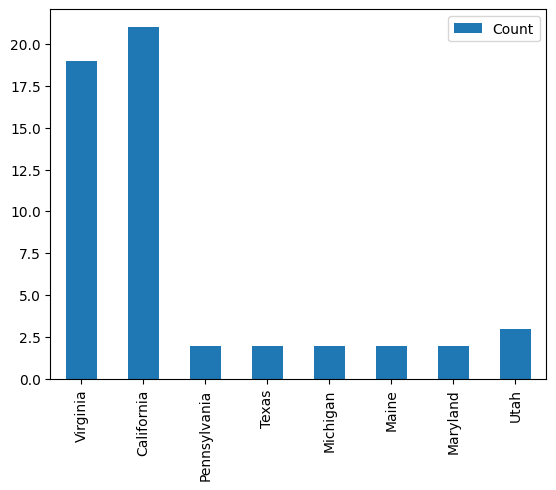

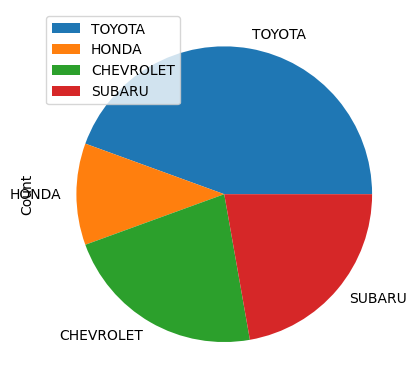

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

dfstate = pd.DataFrame.from_dict(state_detected_license_plates, orient='index', columns=['Count'])
display(dfstate)
dfmake = pd.DataFrame.from_dict(make_detected_license_plates, orient='index', columns=['Count'])
display(dfmake)

dfstate.plot.bar()
plt.savefig('dfstate_bar.jpg')
dfmake.plot.pie(subplots=True)
plt.savefig('dfmake_pie.jpg')

In [30]:
dfstate.to_parquet("State_Detected_Plates.parquet")
dfmake.to_parquet("Make_Detected_Plates.parquet")

In [34]:
key = "Ben/AI/IMAGES_PROCESSED/"
s3.upload_file("State_Detected_Plates.parquet", 
               bucket_name, 
               key+"State_Detected_Plates.parquet")

s3.upload_file("Make_Detected_Plates.parquet", 
               bucket_name, 
               key+"Make_Detected_Plates.parquet")

s3.upload_file("dfmake_pie.jpg",
               bucket_name,
               key+"dfmake_pie.jpg")

s3.upload_file("dfstate_bar.jpg",
               bucket_name,
               key+"dfstate_bar.jpg")